# Implementation of the Forward-Backward Algorithm for Hidden Markov Model

The Forward-Backward allows to compute the **probabilities of hidden states** given observations given the known transition probabilities, emission probabilities and initial hidden state probabilities


In [44]:
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)


This is a (simple) implementation of the Forward-Backward Algorithm inspired from
https://www.youtube.com/watch?v=7zDARfKVm7s&t=5s


![hmm_algo](hmm_algo.png)

#### Notation:

- `T`: transition matrix probabilities: probability of going from hidden state *Z=i* to hidden state *Z=j* 
- `E`: emission probabilities: probability of going from hidden stats *Z=i* to observable state *X=j*
- `pz_init`: probabilities for initial hidden states

In [3]:
# transition matrix
T=np.array([[0.2, 0.3, 0.5],
            [0.7, 0.2, 0.1],
            [0.4, 0.5, 0.1]])

# emission matrix
E=np.array([[0.2, 0.8],
            [0.4, 0.6],
            [0.7, 0.3]])

nz=T.shape[0] # number of states of z
nx = E.shape[1] # number of states of x
x_obs = np.array([0, 1, 1, 0]) #  observed x states
pz_init=np.array([0.1, 0.6, 0.3]) # initial probas of z
if len(pz_init) != nz:
    raise Exception('number of initial probas of z should be %d' % nz)

def p_xk_given_zk(xk, zk):
    return E[zk, xk]
def p_zk_given_zk_prev(zk, zk_prev):
    return T[zk_prev, zk]



## Forward phase

In [4]:
# initialize alpha
def init_alpha():
    alpha=np.zeros(nz)
    for z0 in range(nz):
        alpha[z0] = pz_init[z0] * p_xk_given_zk(x_obs[0],z0)
    return alpha

alpha = init_alpha()
alpha

array([ 0.02,  0.24,  0.21])

In [5]:
def alpha_k_zk(k, zk, alpha_k_prev, debug=False):
    total=0.0
    xk=x_obs[k]
    for zk_prev in range(nz):
        
        if debug is True:
            print('zk_prev: %d' % zk_prev )
            print('p_xk_given_zk(xk, zk): %.5f' % p_xk_given_zk(xk, zk))
            print('p_zk_given_zk_prev(zk, zk_prev): %.5f' % p_zk_given_zk_prev(zk, zk_prev))
            print('alpha_k_prev: %.5f' % alpha_k_prev[zk_prev])
        
        total += p_xk_given_zk(xk, zk) * \
                 p_zk_given_zk_prev(zk, zk_prev) * \
                 alpha_k_prev[zk_prev]
    return total

def alpha_k_inc(k, alpha_k_prev, debug):
    new_alpha = np.zeros(nz)
    for zk in range(nz):
        new_alpha[zk] = alpha_k_zk(k, zk, alpha_k_prev, debug)
    return new_alpha

def alpha_k(k, debug=False):
    alpha = init_alpha()
    for ik in range(0,k):
        alpha = alpha_k_inc(ik+1,alpha, debug)
        if debug is True:
            print(alpha)
    return alpha

In [6]:
print(alpha_k(0))
print(alpha_k(len(x_obs)-1))

[ 0.02  0.24  0.21]
[ 0.01384  0.02205  0.03813]


### Below  is an implementation of forward phase with the log-sum-exp trick to avoid numerical underflow problems

In [10]:
def init_log_alpha():
    alpha = init_alpha()
    return np.log(alpha)

def log_alpha_k_zk(k, zk, log_alpha_k_prev, debug=False):
    total=0.0
    xk=x_obs[k]
             
    ais=np.zeros(nz)
    for zk_prev in range(nz):
        
        p_kx_zk = p_xk_given_zk(xk, zk)
        log_p_kx_zk = np.log(p_kx_zk)
        
        p_zk_zk_prev = p_zk_given_zk_prev(zk, zk_prev)
        log_p_zk_zk_prev = np.log(p_zk_zk_prev)
        if debug:
            print('zk_prev: %d' % zk_prev )
            print('p_xk_given_zk(xk, zk): %.5f; log: %.5f' % (p_kx_zk, log_p_kx_zk))
            print('p_zk_given_zk_prev(zk, zk_prev): %.5f; log: %.5f' % (p_zk_zk_prev,log_p_zk_zk_prev))
            print('log_alpha_k_prev: %.5f' % log_alpha_k_prev[zk_prev])
        
        ais[zk_prev] = log_p_kx_zk + log_p_zk_zk_prev + log_alpha_k_prev[zk_prev]
        
    b = np.max(ais)
    exp_ais = np.exp(ais-b)
    sum_e_ais = np.sum(exp_ais)
    log_alpha = b + np.log(sum_e_ais)
    return log_alpha
    
def log_alpha_k(k, log_alpha_k_prev, debug=False):
    new_log_alpha = np.zeros(nz)
    for zk in range(nz):
        new_log_alpha[zk] = log_alpha_k_zk(k, zk, log_alpha_k_prev, debug)
    return new_log_alpha

In [11]:
log_alpha = init_log_alpha()
log_alpha

array([-3.91202, -1.42712, -1.56065])

In [12]:
for k in range(1,len(x_obs)):
    log_alpha = log_alpha_k(k,log_alpha)
    print(log_alpha)

[-1.58572 -2.34968 -4.10439]
[-2.39172 -2.93253 -3.37913]
[-4.28007 -3.81431 -3.26678]


Check that we obtain the same results as without the log-sum-exp trick

In [13]:
print(np.exp(log_alpha))
print(alpha_k(len(x_obs)-1))

[ 0.01384  0.02205  0.03813]
[ 0.01384  0.02205  0.03813]


**With the simple examples in this notebook, we won't use this trick**

## Backward phase

In [14]:
def beta_k_zk(k, zk, beta_k_next, debug=False):
    total=0.0
    xk_next=x_obs[k+1]
    for zk_next in range(nz):
        
        p_xk_next_zk_next = p_xk_given_zk(xk_next,zk_next)
        p_zk_next_zk      = p_zk_given_zk_prev(zk_next, zk)
        if debug is True:
            print('zk_next: %d' % zk_next )
            print('p(xk+1|zk+1): %.5f' % p_xk_next_zk_next)
            print('p(zk+1|zk): %.5f' % p_zk_next_zk)
            print('beta_k_next: %.5f' % beta_k_next[zk_next])
        
        total += beta_k_next[zk_next] * p_xk_next_zk_next * p_zk_next_zk
    return total

def beta_k_inc(k, beta_k_next, debug=False):
    new_beta = np.zeros(nz)
    for zk in range(nz):
        new_beta[zk] = beta_k_zk(k, zk, beta_k_next, debug)
    return new_beta

def beta_k(k, debug=False):
    beta = np.ones(nz) # initialize beta

    for ik in range(len(x_obs)-1, k,-1):
        beta = beta_k_inc(ik-1, beta, debug)
        if debug is True:
            print(beta)
    return beta

In [15]:
beta_k(0, False)

array([ 0.12848,  0.15186,  0.16671])

In [16]:
print(beta_k(0))
print(beta_k(len(x_obs)-1))

[ 0.12848  0.15186  0.16671]
[ 1.  1.  1.]


In [17]:
def p_zk_x(k):
    return alpha_k(k) * beta_k(k)

In [20]:
p_zk_x_values = np.zeros((len(x_obs),nz))
for k in range(len(x_obs)):
    p_zk_x_values[k] = p_zk_x(k)
print('unnormalized probabilities')
print(p_zk_x_values)

unnormalized probabilities
[[ 0.00257  0.03645  0.03501]
 [ 0.03815  0.03157  0.0043 ]
 [ 0.04665  0.01545  0.01193]
 [ 0.01384  0.02205  0.03813]]


In [52]:
normalization_constant = np.sum(p_zk_x_values, axis=1).reshape(-1,1)
z_probas = p_zk_x_values / normalization_constant
print('Probabilities of the hidden state for each observation')
print(z_probas)

Probabilities of the hidden state for each observation
[[ 1.       0.       0.     ]
 [ 0.00235  0.99378  0.00386]
 [ 0.02152  0.00408  0.9744 ]
 [ 0.97336  0.00446  0.02218]
 [ 0.00521  0.98957  0.00522]
 [ 0.02256  0.00459  0.97285]
 [ 0.97263  0.00463  0.02274]
 [ 0.0056   0.98881  0.00559]
 [ 0.02512  0.00609  0.96879]
 [ 0.95639  0.00694  0.03667]
 [ 0.02961  0.95235  0.01805]]


## Check the algo with a simple example
Use probabilities that yield an **almost deterministic** behavior.

- The most likely hidden state sequence is 0,1,2,0,1,2,0,1,2...etc...   
- The most likely observable sequence is   1,0,1,1,0,1,1,0,1,1...etc...

<img src="HMM1.png" align="left" style="width: 700px;"/>

In [58]:
# transition matrix
T=np.array([[0.1, 0.8, 0.1],
            [0.1, 0.1, 0.8],
            [0.8, 0.1, 0.1]])

# emission matrix
E=np.array([[0.1, 0.9],
            [0.9, 0.1],
            [0.1, 0.9]])

nz=T.shape[0] # number of states of z
nx = E.shape[1] # number of states of x
x_obs = np.array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]) #  observed x states
pz_init=np.array([1.0, 0.0, 0.0]) # initial probas of z
if len(pz_init) != nz:
    raise Exception('number of initial probas of z should be %d' % nz)

In [59]:
p_zk_x_values = np.zeros((len(x_obs),nz))
for k in range(len(x_obs)):
    p_zk_x_values[k] = p_zk_x(k)
normalization_constant = np.sum(p_zk_x_values, axis=1).reshape(-1,1)
z_probas = p_zk_x_values / normalization_constant
print('Probabilities of the hidden state for each observation')
print(z_probas)

Probabilities of the hidden state for each observation
[[ 1.       0.       0.     ]
 [ 0.00235  0.99378  0.00386]
 [ 0.02152  0.00408  0.9744 ]
 [ 0.97336  0.00446  0.02218]
 [ 0.00521  0.98957  0.00522]
 [ 0.02256  0.00459  0.97285]
 [ 0.97263  0.00463  0.02274]
 [ 0.0056   0.98881  0.00559]
 [ 0.02512  0.00609  0.96879]
 [ 0.95639  0.00694  0.03667]
 [ 0.02961  0.95235  0.01805]]


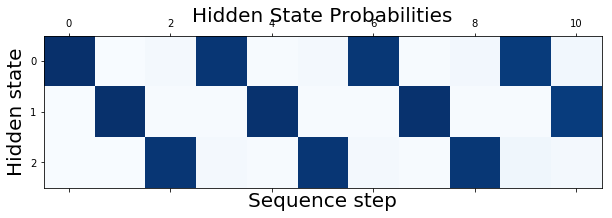

In [60]:
def show_hidden_state_probabilities(z_probas):
    ax = plt.figure(figsize=(10,8)).add_subplot(1, 1, 1)
    _ = ax.matshow(z_probas.T, cmap=plt.cm.Blues)
    ax.set_ylabel('Hidden state',fontsize=20)
    ax.set_xlabel('Sequence step',fontsize=20)
    ax.set_title('Hidden State Probabilities',fontsize=20)
    
show_hidden_state_probabilities(z_probas)

## Verify we obtain the same probabilities with HMMLEARN

In [61]:
# conda install -c omnia hmmlearn
# better create in a separate conda env since uses numpy 1.12 (downgrade from 1.14)
from hmmlearn import hmm

# Create a Multinomial HMM with hidden state that can take 3 values
hmm_model = hmm.MultinomialHMM(n_components=3, n_iter=0, random_state=1000, init_params='')
# Reuse the same par
hmm_model.transmat_ = T.copy()
hmm_model.emissionprob_ = E.copy()
hmm_model.startprob_ = pz_init.copy()

# Use the same observations
observations = x_obs.reshape(-1,1)

# # Fit the model using the Forward-Backward algorithm
#hmm_model.fit(observations)

z_probas=hmm_model.predict_proba(observations, lengths=None)
print('Probabilities of the hidden state for each observation')
print(z_probas)

Probabilities of the hidden state for each observation
[[ 1.       0.       0.     ]
 [ 0.00235  0.99378  0.00386]
 [ 0.02152  0.00408  0.9744 ]
 [ 0.97336  0.00446  0.02218]
 [ 0.00521  0.98957  0.00522]
 [ 0.02256  0.00459  0.97285]
 [ 0.97263  0.00463  0.02274]
 [ 0.0056   0.98881  0.00559]
 [ 0.02512  0.00609  0.96879]
 [ 0.95639  0.00694  0.03667]
 [ 0.02961  0.95235  0.01805]]


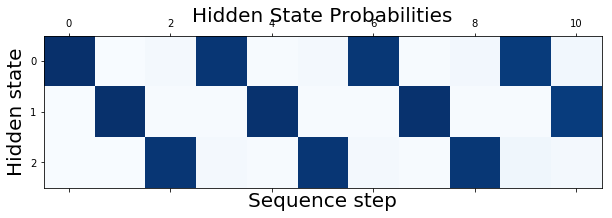

In [62]:
show_hidden_state_probabilities(z_probas)

## Change observations of steps 5 and 6 and see impact on probabilities of hidden states

[[ 1.       0.       0.     ]
 [ 0.00272  0.99294  0.00435]
 [ 0.02617  0.00729  0.96654]
 [ 0.93717  0.00749  0.05534]
 [ 0.06542  0.91433  0.02025]
 [ 0.112    0.30944  0.57856]
 [ 0.57714  0.31121  0.11164]
 [ 0.02147  0.90884  0.06969]
 [ 0.06218  0.01014  0.92768]
 [ 0.94338  0.01234  0.04428]
 [ 0.03312  0.94619  0.02069]]


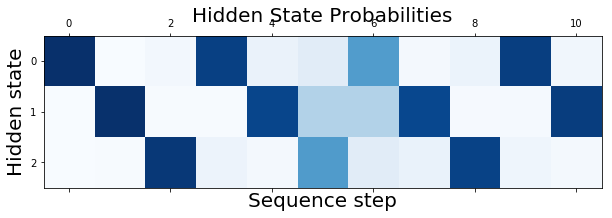

In [63]:
observations[5,0] = 0
observations[6,0] = 0
z_probas=hmm_model.predict_proba(observations, lengths=None)
print(z_probas)
show_hidden_state_probabilities(z_probas)